# Use a function to map two dimensional to one dimension
## Function1: lowest bound
$$\text{lower bound} = \Delta H_0 - \Delta H_0/n_\sigma$$

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import genextreme
import matplotlib.pyplot as plt
from scipy.special import erfinv
import math
plt.style.use('./nice.mplstyle')

def load_data(file_path, data_type='mc'):
    data = pd.read_csv(file_path)
    if data_type == 'direct_compare':
        data['Delta_H0'] *= 100
    return data

def extract_data(data, relation):
    df = data[data['Relations'] == relation]
    if 'Delta_H0' in df.columns:
        delta_h0 = df['Delta_H0'].values
    else:
        delta_h0 = df['$\Delta H_0\,(\%)$'].values
    if 'Significance $(\sigma)$' in df.columns:
        significance = df['Significance $(\sigma)$'].values
    else:
        significance = df['Significance'].values
    return delta_h0, significance

def calculate_sigma_p_value(delta_h0_proj, target_value):
    median = np.median(delta_h0_proj)
    sigma_84th = np.percentile(delta_h0_proj, 84)
    sigma = sigma_84th - median
    sigma_deviation = np.abs((target_value - median) / sigma)
    p_value_sigma = 1 - math.erf(sigma_deviation / np.sqrt(2))
    return sigma_deviation, p_value_sigma

def calculate_gev_p_value(delta_h0_proj, target_value, fscale=None):
    # Fit GEV to the data
    if fscale is None:
        params = genextreme.fit(delta_h0_proj)
    else:
        params = genextreme.fit(delta_h0_proj, fscale=fscale)
    shape, loc, scale = params

    # Calculate the p-value using the CDF of the fitted GEV distribution
    p_value_gev = 1 - genextreme.cdf(target_value, *params)

    # Transform to sigma (Gaussian equivalent deviation)
    sigma_deviation = np.sqrt(2) * erfinv(1 - p_value_gev)

    return p_value_gev, sigma_deviation

# The first projection function
def default_proj(delta_H0, n_sigma):
    return delta_H0 - delta_H0 / n_sigma

Prob of obtaining (ΔH%, nσ) = [8.7 2.4] in $L_\mathrm{{X}}-T$.
Sigma deviation: 2.88σ, p-value: 0.00403
Probability of target value: 0.0456, (2sigma)


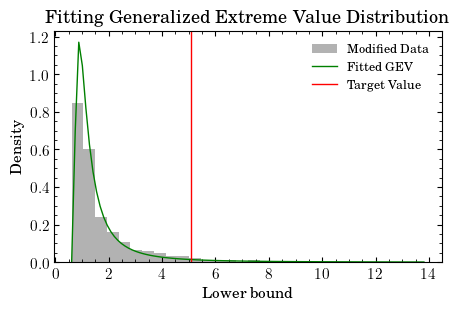

Prob of obtaining (ΔH%, nσ) = [14.   2.6] in $Y_\mathrm{{SZ}}-T$.
Sigma deviation: 9.26σ, p-value: 0
Probability of target value: 0.0101, (2.57sigma)


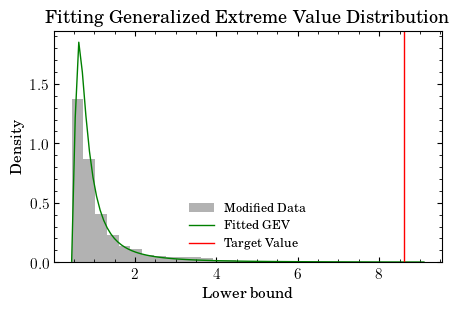

In [ ]:
# Example usage for mc data
file_path_mc = '/cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/h0_mc_all.csv'
data_type_mc = 'mc'
data_mc = load_data(file_path_mc, data_type_mc)

target_point_arr_mc = [np.array([8.7, 2.4]), np.array([14, 2.6])]
for relation, target_point in zip(['$L_\\mathrm{{X}}-T$', '$Y_\\mathrm{{SZ}}-T$'], target_point_arr_mc):
    print(f'Prob of obtaining (ΔH%, nσ) = {target_point} in {relation}.')
    delta_h0, significance = extract_data(data_mc, relation)
    delta_h0_proj = default_proj(delta_h0, significance)
    target_value = default_proj(target_point[0], target_point[1])
    
    sigma_deviation, p_value_sigma = calculate_sigma_p_value(delta_h0_proj, target_value)
    print(f"Sigma deviation: {sigma_deviation:.3g}σ, p-value: {p_value_sigma:.3g}")
    
    p_value_gev, sigma_gev = calculate_gev_p_value(delta_h0_proj, target_value)
    print(f"Probability of target value: {p_value_gev:.3g}, ({sigma_gev:.3g}sigma)")
    
    # Plotting results
    params = genextreme.fit(delta_h0_proj)
    shape, loc, scale = params
    
    plt.figure(figsize=(5, 3))
    plt.hist(delta_h0_proj, bins=30, density=True, alpha=0.6, color='gray', label='Modified Data')
    x_vals = np.linspace(0, delta_h0_proj.max(), 100)
    gev_pdf = genextreme.pdf(x_vals, shape, loc, scale)
    plt.plot(x_vals, gev_pdf, color='g', label='Fitted GEV')
    plt.axvline(target_value, color='red', linestyle='-', label='Target Value')
    plt.xlabel('Lower bound')
    plt.ylabel('Density')
    plt.legend(fontsize=9)
    plt.title('Fitting Generalized Extreme Value Distribution')
    plt.show()



Prob of obtaining (ΔH%, nσ) = [8.7 2.6] in $L_\mathrm{{X}}-T$.
Sigma deviation: 1.96σ, p-value: 0.0497
Probability of target value: 0.0249, (2.24sigma)
0.20711620233681166 1.6098136464039137 1.4533917043508473


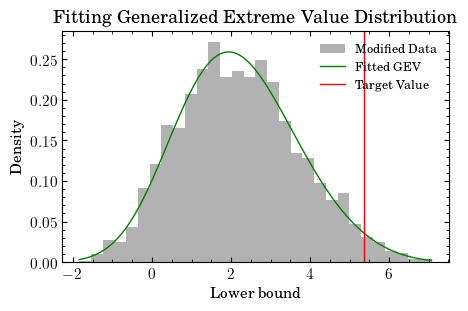

Prob of obtaining (ΔH%, nσ) = [14.   4.1] in $Y_\mathrm{{SZ}}-T$.
Sigma deviation: 6.42σ, p-value: 1.39e-10
Probability of target value: 0, (infsigma)
0.22464441992167622 1.5480369302389292 1.2839869864496367


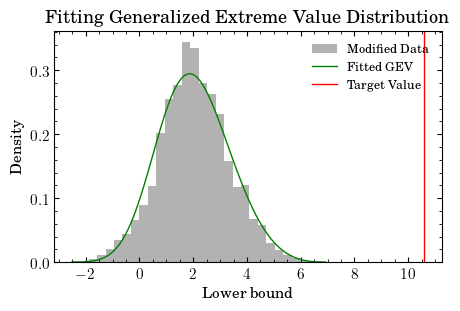

In [33]:

# Direct compare
file_path_direct_compare = '/cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/h0_direct_compare.csv'
data_type_direct_compare = 'direct_compare'
data_direct_compare = load_data(file_path_direct_compare, data_type_direct_compare)

target_point_arr_direct_compare = [np.array([8.7, 2.6]), np.array([14, 4.1])]
for relation, target_point in zip(['$L_\\mathrm{{X}}-T$', '$Y_\\mathrm{{SZ}}-T$'], target_point_arr_direct_compare):
    print(f'Prob of obtaining (ΔH%, nσ) = {target_point} in {relation}.')
    delta_h0, significance = extract_data(data_direct_compare, relation)
    delta_h0_proj = default_proj(delta_h0, significance)
    target_value = default_proj(target_point[0], target_point[1])
    
    sigma_deviation, p_value_sigma = calculate_sigma_p_value(delta_h0_proj, target_value)
    print(f"Sigma deviation: {sigma_deviation:.3g}σ, p-value: {p_value_sigma:.3g}")

    p_value_gev, sigma_gev = calculate_gev_p_value(delta_h0_proj, target_value)
    print(f"Probability of target value: {p_value_gev:.3g}, ({sigma_gev:.3g}sigma)")
    
    # Plotting results
    params = genextreme.fit(delta_h0_proj)
    shape, loc, scale = params
    print(shape, loc, scale)
    
    plt.figure(figsize=(5, 3))
    plt.hist(delta_h0_proj, bins=30, density=True, alpha=0.6, color='gray', label='Modified Data')
    x_vals = np.linspace(delta_h0_proj.min(), delta_h0_proj.max(), 100)
    gev_pdf = genextreme.pdf(x_vals, shape, loc, scale)
    plt.plot(x_vals, gev_pdf, color='g', label='Fitted GEV')
    plt.axvline(target_value, color='red', linestyle='-', label='Target Value')
    plt.xlabel('Lower bound')
    plt.ylabel('Density')
    plt.legend(fontsize=9)
    plt.title('Fitting Generalized Extreme Value Distribution')
    plt.show()



1727
1726
Prob of obtaining (ΔH%, nσ) = [9.  5.4] in joint result.
Sigma deviation: 6.07σ, p-value: 1.27e-09
Probability of target value: 0.0231, (2.27sigma)


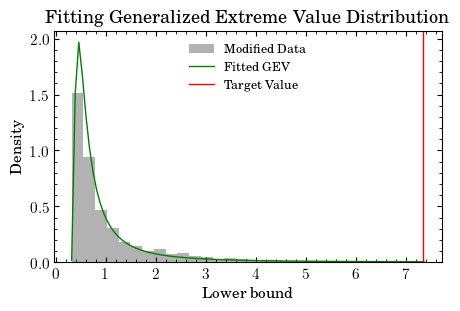

In [ ]:

# Additional loop for the joint result
file_path_joint = '../data/analysis_all/h0_mc_joint_all.csv'
data_joint = load_data(file_path_joint, 'joint')
print(len(data_joint))
data_joint = data_joint[data_joint['DeltaH0'] < 15]
print(len(data_joint))
target_point_joint = np.array([9.0, 5.4])

print(f'Prob of obtaining (ΔH%, nσ) = {target_point_joint} in joint result.')
delta_h0_joint = data_joint['DeltaH0'].values
significance_joint = data_joint['Significance'].values
delta_h0_proj_joint = default_proj(delta_h0_joint, significance_joint)
target_value_joint = default_proj(target_point_joint[0], target_point_joint[1])

sigma_deviation_joint, p_value_sigma_joint = calculate_sigma_p_value(delta_h0_proj_joint, target_value_joint)
print(f"Sigma deviation: {sigma_deviation_joint:.3g}σ, p-value: {p_value_sigma_joint:.3g}")

p_value_gev_joint, sigma_gev_joint = calculate_gev_p_value(delta_h0_proj_joint, target_value_joint)
print(f"Probability of target value: {p_value_gev_joint:.3g}, ({sigma_gev_joint:.3g}sigma)")

# Plotting results for joint result
params_joint = genextreme.fit(delta_h0_proj_joint)
shape_joint, loc_joint, scale_joint = params_joint

plt.figure(figsize=(5, 3))
plt.hist(delta_h0_proj_joint, bins=30, density=True, alpha=0.6, color='gray', label='Modified Data')
x_vals_joint = np.linspace(0, delta_h0_proj_joint.max(), 100)
gev_pdf_joint = genextreme.pdf(x_vals_joint, shape_joint, loc_joint, scale_joint)
plt.plot(x_vals_joint, gev_pdf_joint, color='g', label='Fitted GEV')
plt.axvline(target_value_joint, color='red', linestyle='-', label='Target Value')
plt.xlabel('Lower bound')
plt.ylabel('Density')
plt.legend(fontsize=9)
plt.title('Fitting Generalized Extreme Value Distribution')
plt.show()
